In [32]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

1. Carga dos dados

In [33]:
# Caminho do arquivo Excel
pathfile = './data/20240801_Planilhas_com_respostas_mdc_OCULTO.xlsx'

# Carrega a aba específica do arquivo
df = pd.read_excel(pathfile, sheet_name='20240801_Planilhas_com_resposta')

# Mapeamento do campo Tipo de Desligamento com o Y
tipo_desligamento_dict = pd.read_excel(pathfile, sheet_name='Tipo Desligamento > Y')

In [34]:
# Calcular o tempo de empresa em meses
def calcular_tempo_em_meses(A, B):
    if pd.isna(A) or pd.isna(B):
        return None
    data_A = A
    data_B = B
    diff = relativedelta(data_B, data_A)
    return diff.years * 12 + diff.months

2. Preprocessamento

2.1 Calcular o tempo de empresa em meses

In [35]:
# Converter 'data_contratacao' para datetime
df['f_data_contratacao'] = pd.to_datetime(df['Data de contratação (mês/ano)'])

# Tratar a coluna 'data_desligamento'
df['f_data_ref'] = df['Data de desligamento (mês/ano)'].apply(
    lambda x: datetime.today().strftime('%d/%m/%Y') if x == 'Não se aplica' else x
)

# Converter 'data_desligamento' para datetime com formato específico
df['f_data_ref'] = pd.to_datetime(df['f_data_ref'], format='%d/%m/%Y', errors='coerce')

# Aplicar a função ao DataFrame
df['f_tempo_empresa_meses'] = df.apply(
    lambda row: calcular_tempo_em_meses(row['f_data_contratacao'], row['f_data_ref']),
    axis=1
)

2.2 Agrupar por pessoa
-  Concatenar atributos com valores distintos por pessoa usando ","

In [36]:
# Calcular os atributos com 2 ou mais valores distintos
distinct_counts = df.groupby('pessoa').nunique()
attributes_with_distinct_values = distinct_counts.columns[(distinct_counts >= 2).any()].tolist()

# Concatenar os valores distintos dos atributos selecionados em strings separadas por atributo
concatenated_distinct_values = df.groupby('pessoa')[attributes_with_distinct_values].apply(
    lambda x: x.apply(lambda y: ', '.join(map(str, sorted(y.unique()))))
)

# Manter os outros atributos (que não estão em attributes_with_distinct_values)
other_attributes = df.groupby('pessoa').first().drop(columns=attributes_with_distinct_values)

# Juntar todos os atributos no result final
df_por_pessoa = concatenated_distinct_values.join(other_attributes)

2.3 Substituir o campo Tipo de Desligamento por Y (ativo,voluntário,involuntário)

In [37]:
# Criar um dicionário de mapeamento da coluna A para B no dataframe2
map_dict = dict(zip(tipo_desligamento_dict['Tipo de desligamento'], tipo_desligamento_dict['Y']))

# Mapear o conteúdo de A em dataframe1 e trazer o valor correspondente de B
df_por_pessoa['Y'] = df_por_pessoa['Tipo de desligamento'].map(map_dict)

2.4 Calcular a faixa salarial do cargo
- A faixa salarial do cargo será o menor e o maior valor observado

In [38]:
# Extrair os valores numéricos da faixa salarial
df_por_pessoa[['f_Faixa_min', 'f_Faixa_max']] = df_por_pessoa['Faixa salarial'].str.extract(r'R\$(\d{1,2}\.?\d{0,3},\d{2}) .+ R\$(\d{1,2}\.?\d{0,3},\d{2})')
df_por_pessoa['f_Faixa_min'] = df_por_pessoa['f_Faixa_min'].str.replace('.', '').str.replace(',', '.').astype(float)
df_por_pessoa['f_Faixa_max'] = df_por_pessoa['f_Faixa_max'].str.replace('.', '').str.replace(',', '.').astype(float)
df_por_pessoa['f_Faixa_med'] = (df_por_pessoa['f_Faixa_max'] + df_por_pessoa['f_Faixa_min']) / 2

# Agrupar por cargo e encontrar os valores mínimos e máximos para faixa salarial
result = df_por_pessoa.groupby('Cargo').agg(
    f_Faixa_min_cargo=('f_Faixa_min', 'min'),
    f_Faixa_max_cargo=('f_Faixa_max', 'max'),
    f_Faixa_med_cargo=('f_Faixa_med', 'mean')
).reset_index()

# Fazer merge do resultado agregado com o DataFrame original para ter os valores de Faixa_min e Faixa_max do cargo
df_por_pessoa = df_por_pessoa.merge(result, on='Cargo', suffixes=('', '_cargo'))

# Definir condições para a coluna f_Faixa_pos
condicoes = [
    (df_por_pessoa['f_Faixa_med'] < df_por_pessoa['f_Faixa_med_cargo']),
    (df_por_pessoa['f_Faixa_med'] > df_por_pessoa['f_Faixa_med_cargo'])
]

# Definir valores correspondentes para as condições
valores = [-1, 1]

# Aplicar as condições e definir 0 para os casos em que nenhuma condição é satisfeita
df_por_pessoa['f_Faixa_pos'] = np.select(condicoes, valores, default=0)

# Criar a coluna com o intervalo de faixa salarial formatado
result['Faixa salarial'] = 'Entre R$' + result['f_Faixa_min_cargo'].apply(lambda x: f"{x:,.2f}") + ' e R$' + result['f_Faixa_max_cargo'].apply(lambda x: f"{x:,.2f}")

# Selecionar apenas as colunas de interesse
result = result[['Cargo', 'Faixa salarial']]

# Criar um dicionário de mapeamento da coluna A para B no dataframe2
map_dict = dict(zip(result['Cargo'], result['Faixa salarial']))

# Mapear o conteúdo de A em dataframe1 e trazer o valor correspondente de B
df_por_pessoa['f_Faixa_Salarial_Min_Max_cargo'] = df_por_pessoa['Cargo'].map(map_dict)

2.5 Recalcular o tempo de treinamento

In [39]:
# Converter para valores numéricos e substituir valores inválidos por NaN
df_por_pessoa['f_Horas_de_treinamento'] = pd.to_numeric(df_por_pessoa['Horas de treinamento'], errors='coerce')

# Definir um teto de 2000 horas para valores acima de 2000
df_por_pessoa['f_Horas_de_treinamento'] = df_por_pessoa['f_Horas_de_treinamento'].apply(lambda x: min(x, 2000))

2.6 Salvar o resultado do pré-processamento

In [40]:
file_path = './data/saida/1-df_preprocessamento.xlsx'
# Salvar o DataFrame em uma planilha Excel
df_por_pessoa.to_excel(file_path, index=False)

# Criar um novo dataframe com informações sobre as colunas
summary_data = {
    "Column": [],
    "DataType": [],
    "MissingValues": [],
    "DistinctValues": [],
}

for col in df_por_pessoa.columns:
    data_type = df_por_pessoa[col].dtype
    missing_values = df_por_pessoa[col].isnull().sum()
    distinct_values = df_por_pessoa[col].nunique()
    
    summary_data["Column"].append(col)
    summary_data["DataType"].append(data_type)
    summary_data["MissingValues"].append(missing_values)
    summary_data["DistinctValues"].append(distinct_values)

# Converter o dicionário em um novo dataframe
summary_df = pd.DataFrame(summary_data)

# Salvar o dataframe em um arquivo Excel
file_path = "./data/saida/1-df_preprocessamento_summary.xlsx"
summary_df.to_excel(file_path, index=False)

3. Limpeza e normalização

In [41]:
campos = [
       #'Cargo',                                # Encoding
       #'Faixa salarial',
       #'Data de contratação (mês/ano)',
       #'Data de desligamento (mês/ano)',
       #'Tempo de empresa',
       #'Horas de treinamento',
       'Afastamentos (dias/ano)',              # Transformar para numérico
       'Outros',                               # Se tem plano odontológico, etc... Encoding
       #'Tipo de desligamento',
       #'Motivo desligamento',
       #'habilidade_mdc',
       #'categoria_mdc',
       #'conhecimento_mdc',
       #'grau_habilidade_mdc',
       #'f_data_contratacao',
       #'f_data_ref',
       'f_tempo_empresa_meses',
       #'Cidade Empresa', 
       #'Cidade Funcionario',                   # Calcular um campo com a distancia da cidade do funcionario com a empresa. Serve só para os modelos híbridos.
       #'Escritório da Empresa',
       'Modelo Trabalho',                       # Encoding
       'Faixa de Idade',                        # Encoding
       'Gênero',                                # Encoding
       'Tempo de experiência (anos)',           # Converter para numérico
       'Tipo de Contrato',                      # Encoding
       'Modelo de trabalho',
       'Jornada de Trabalho',                   # Excluir o Não informado. Encoding no restante.
       'Formação',                              # Excluir o Não informado (esta escrito errado). Encoding no restante.
       #'Certificações',                         # Excluir o Não temos registros. Transformar para numérico. <-- excluido -- 93% de dados faltantes.
       'Ticket',                                # Sim ou Não. Converter para binário.
       'Seguro saúde',                          # Sim ou Não. Converter para binário.
       'Seguro de Vida',                        # Sim ou Não. Converter para binário.
       #'Vale Transporte',                      # Tudo não.
       #'Nota avaliação desempenho 2022',        # Excluir 'Não foi avaliado nesse ciclo'. Transformar para numérico. <-- excluido -- 67% de dados faltantes.
       'Nota avaliação desempenho 2023',        # Excluir 'Não foi avaliado nesse ciclo'. Transformar para numérico. 
       #'Busca mudança no trabalho',            # null
       #'Conhecimentos listados',               # null
       #'Competências listadas',                # null
       #'Certificações listadas',               # <-- pensar. Deve estar correlacionado com o n. de certificações.
       #'Certificações desejadas',              # null
       #'Treinamentos Realizados Udemy',        # null
       #'Treinamentos Realizados Alura',        # null
       #'Treinamentos Desejados',               # null
       #'Interesses',                           # null
       'Y',                                     # ativo,voluntário,involuntário
       #'f_Faixa_min',
       #'f_Faixa_max',
       #'f_Faixa_med',
       #'f_Faixa_min_cargo',
       #'f_Faixa_max_cargo',
       #'f_Faixa_med_cargo',
       'f_Faixa_pos',
       #'f_Faixa_Salarial_Min_Max_cargo', 
       'f_Horas_de_treinamento'
]

# Manter apenas os campos selecionados
df = df_por_pessoa[campos]

# Campos para transformar em numérico
campos = [
    'Afastamentos (dias/ano)',
    'f_tempo_empresa_meses',
    'Tempo de experiência (anos)',
    #'Certificações',
    #'Nota avaliação desempenho 2022',
    'Nota avaliação desempenho 2023',
    'f_Horas_de_treinamento'
]
# Transformar os campos para numérico usando .loc para evitar o aviso de cópia
for campo in campos:
    df.loc[:, campo] = pd.to_numeric(df[campo], errors='coerce')

# Transformar os campos para hot encoding
campos = [
    'Jornada de Trabalho',
    'Formação',
    #'Cargo',
    'Outros',
    'Modelo Trabalho',
    'Faixa de Idade',
    'Gênero',
    'Tipo de Contrato',
    'Modelo de trabalho'
]
for campo in campos:
    # Filtrar os valores diferentes de 'Não informado' e realizar o one-hot encoding
    df_encoded = pd.get_dummies(df[campo])
    df_encoded = df_encoded.drop(columns=[col for col in df_encoded.columns if 'informado' in col])
    # Concatenar o resultado com o dataframe original, excluindo a coluna original
    df = pd.concat([df, df_encoded], axis=1).drop(columns=[campo])

# Converter 'Sim' para 1 e 'Não' para 0 na coluna 'Ticket'
df['Ticket'] = df['Ticket'].map({'Sim': 1, 'Não': 0}).astype(bool)

# Converter 'Sim' para 1 e 'Não' para 0 na coluna 'Seguro saúde'
df['Seguro saúde'] = df['Seguro saúde'].map({'Sim': 1, 'Não': 0}).astype(bool)

# Converter 'Sim' para 1 e 'Não' para 0 na coluna 'Seguro de Vida'
df['Seguro de Vida'] = df['Seguro de Vida'].map({'Sim': 1, 'Não': 0}).astype(bool)

# Campos com pouca ou nenhuma variação.
df = df.drop(columns=['Do 6º ao 9º ano do Ensino Fundamental incompleto (antiga 5ª à 8ª série)'])
df = df.drop(columns=['Aprendiz'])
df = df.drop(columns=['Plano Odontológico, PLR, Folga Anual, Reembolso de Certificações, PrimeUp Academy e Programa de Indicações (Amigo Prime), Plano Odontológico, PLR, Folga Anual, Reembolso de Certificações, PrimeUp Academy, Programa de Indicações (Amigo Prime), TotalPass e Programa Optum'])
df = df.drop(columns=['Sócio'])

# Salvar o dataframe em um arquivo Excel
file_path = "./data/saida/2-df_limpeza.xlsx"
df.to_excel(file_path, index=False)

In [42]:
# Função para sumarizar o DataFrame
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Feature': df.columns,
        'Missing Values': df.isnull().sum(),
        'Missing %': df.isnull().mean() * 100,
        'Distinct Count': df.nunique(),
        'Distinct %': (df.nunique() / len(df)) * 100,
        'True Count': [df[col].sum() if df[col].dtype == 'bool' else None for col in df.columns],
        'True %': [df[col].mean() * 100 if df[col].dtype == 'bool' else None for col in df.columns],
        'False Count': [len(df) - df[col].sum() - df[col].isnull().sum() if df[col].dtype == 'bool' else None for col in df.columns],
        'False %': [(len(df) - df[col].sum() - df[col].isnull().sum()) / len(df) * 100 if df[col].dtype == 'bool' else None for col in df.columns]
    })
    return summary

# Aplicar a função e exibir a sumarização
summary_df = summarize_dataframe(df)

# Salvar o dataframe em um arquivo Excel
file_path = "./data/saida/2-df_limpeza_summary.xlsx"
summary_df.to_excel(file_path, index=False)


4. Tratamento da classe

In [43]:
# Criar um novo atributo 'Y_classe' com os valores mapeados de 'Y'
#df['Y'] = df['Y'].map({"Involuntário": 0, "Voluntário": 1})
df['Y'] = df['Y'].map({"Colaborador ativo": 0, "Voluntário": 1})

# Remover as instâncias com "Colaborador ativo" (agora mapeadas como NaN)
df = df.dropna(subset=['Y']).reset_index(drop=True)

# Salvar o dataframe em um arquivo Excel
file_path = "./data/saida/3-df_tratamento_classe.xlsx"
df.to_excel(file_path, index=False)

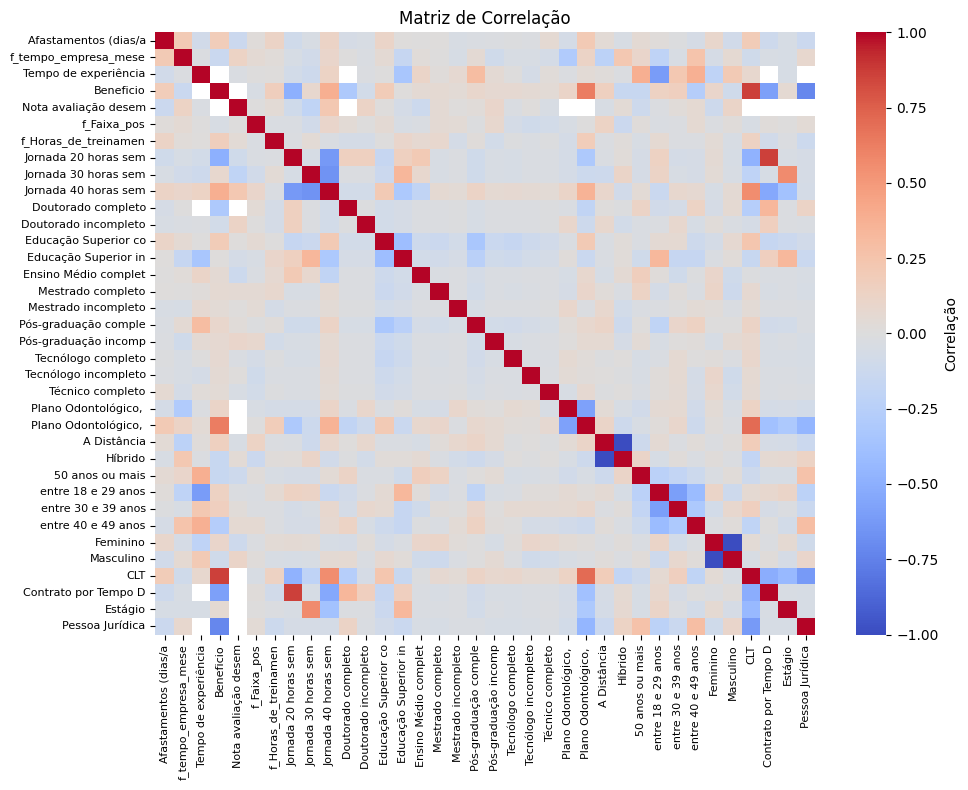

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dividindo os dados
X = df.drop('Y', axis=1)

# Limpando os dados com correlação
X = X.drop(['Seguro saúde',
            'Seguro de Vida',
            'Não',
            'Folga Anual, Reembolso de Certificações, PrimeUp Academy, TotalPass e Programa Optum',
            'Programa de Indicações (Amigo Prime)'], axis=1)
# Renomeando a coluna 'Ticket' para 'Beneficio'
X = X.rename(columns={'Ticket': 'Beneficio'})

# Assumindo que correlation_matrix já está calculada
# Truncando os labels para no máximo 10 caracteres
labels = [col[:20] for col in X.columns]

# Arredondando a matriz de correlação para 2 casas decimais
correlation_matrix = X.corr().round(2)

# Configurando o tamanho da figura
plt.figure(figsize=(10, 8))

# Criando o heatmap com labels truncados e fonte menor
sns.heatmap(correlation_matrix, 
            annot=False,                # Exibir valores
            fmt='.2f',                # Formato com 2 casas decimais
            cmap='coolwarm',          # Paleta de cores
            vmin=-1, vmax=1,          # Escala de correlação
            xticklabels=labels,        # Labels truncados para o eixo x
            yticklabels=labels,        # Labels truncados para o eixo y
            annot_kws={'size': 8},    # Tamanho da fonte das anotações (menor)
            cbar_kws={'label': 'Correlação'})  # Rótulo da barra de cores

# Definindo o título
plt.title('Matriz de Correlação')

# Ajustando o tamanho da fonte dos labels dos eixos
plt.xticks(fontsize=8)  # Tamanho da fonte do eixo x
plt.yticks(fontsize=8)  # Tamanho da fonte do eixo y

# Otimizando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()


5. Treinamento

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# Dicionário de labels para as classes
label_map = {
    0: "Colaborador ativo",
    1: "Desligamento Voluntário"
}

def plot_roc_and_confusion(X_test, y_test, y_pred, model_name, model):
    # Ordena os labels conforme as classes do modelo
    ordered_labels = [label_map[i] for i in model.classes_]

    # Curva ROC (apenas para problemas binários)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.title(f"Curva ROC - {model_name}")
        plt.xlabel("Taxa de Falsos Positivos (FPR)")
        plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ O modelo {model_name} não possui 'predict_proba', não é possível calcular a curva ROC.")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_labels)
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.tight_layout()
    plt.show()


🔍 Treinando e otimizando: RandomForest-withoutImputer
Fitting 5 folds for each of 27 candidates, totalling 135 fits

✅ Melhor combinação de hiperparâmetros para RandomForest-withoutImputer:
{'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 12, 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__n_estimators': 100}
🎯 Acurácia: 0.92
🎯 F1 Macro: 0.90
📊 Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        57
         1.0       1.00      0.73      0.84        22

    accuracy                           0.92        79
   macro avg       0.95      0.86      0.90        79
weighted avg       0.93      0.92      0.92        79



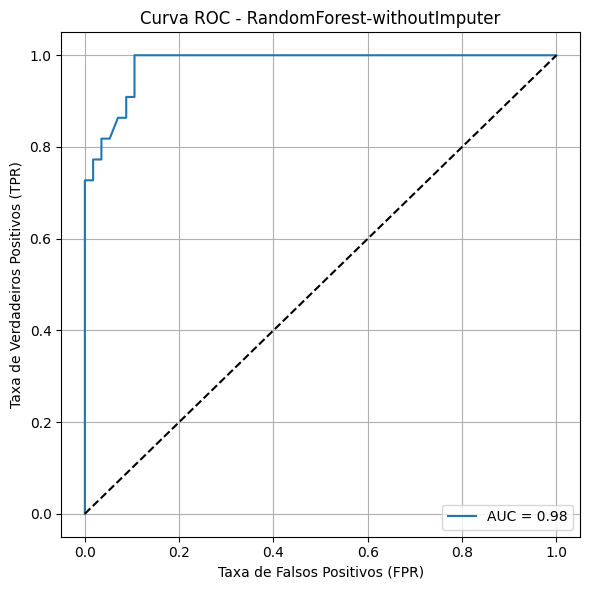

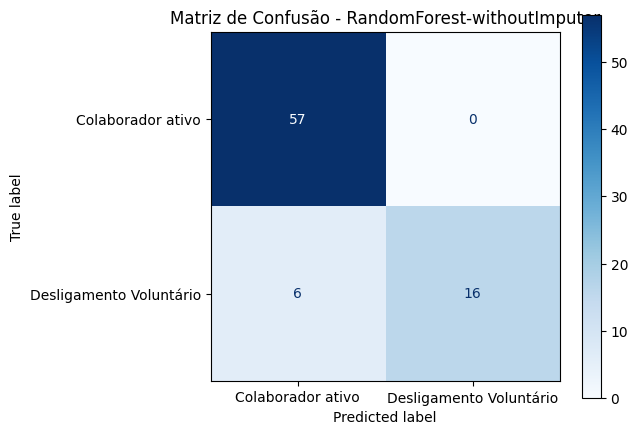


🔍 Treinando e otimizando: RandomForest
Fitting 5 folds for each of 27 candidates, totalling 135 fits

✅ Melhor combinação de hiperparâmetros para RandomForest:
{'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 12, 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__n_estimators': 100}
🎯 Acurácia: 0.91
🎯 F1 Macro: 0.88
📊 Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        57
         1.0       1.00      0.68      0.81        22

    accuracy                           0.91        79
   macro avg       0.95      0.84      0.88        79
weighted avg       0.92      0.91      0.91        79



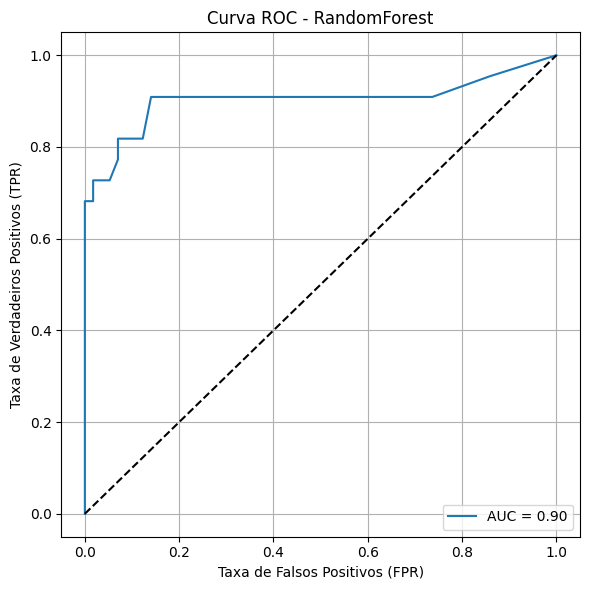

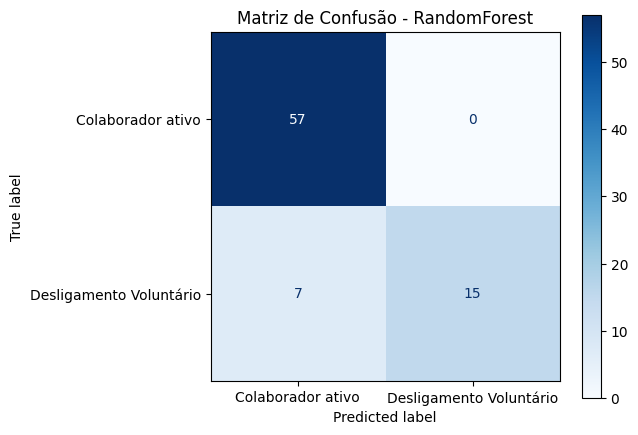


🔍 Treinando e otimizando: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits

✅ Melhor combinação de hiperparâmetros para LogisticRegression:
{'classifier__C': 1.0, 'classifier__solver': 'lbfgs'}
🎯 Acurácia: 0.81
🎯 F1 Macro: 0.78
📊 Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.90      0.82      0.86        57
         1.0       0.63      0.77      0.69        22

    accuracy                           0.81        79
   macro avg       0.77      0.80      0.78        79
weighted avg       0.83      0.81      0.82        79



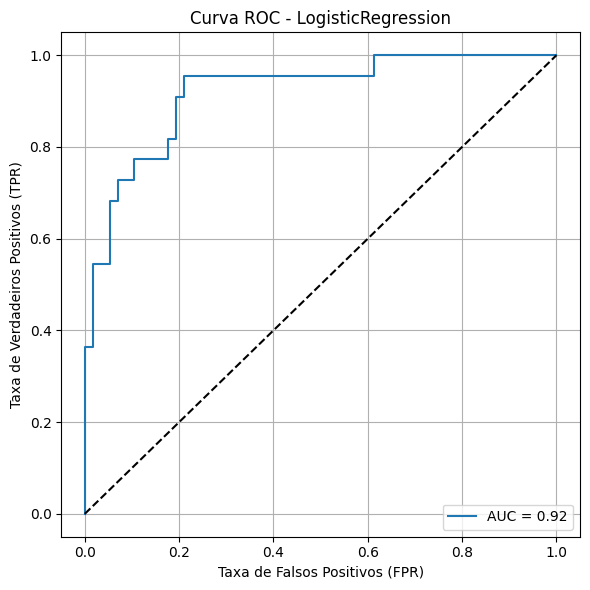

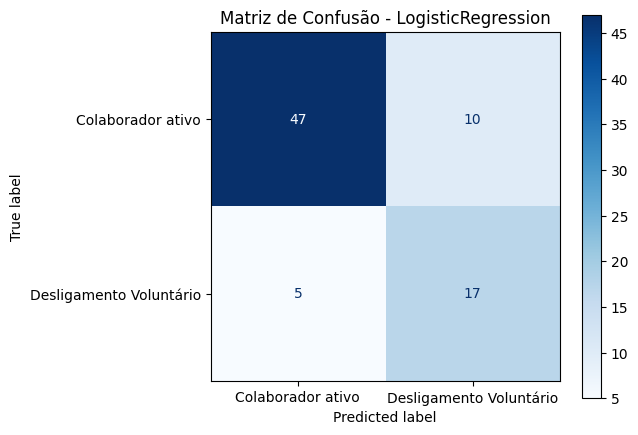


🔍 Treinando e otimizando: SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Melhor combinação de hiperparâmetros para SVM:
{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
🎯 Acurácia: 0.89
🎯 F1 Macro: 0.86
📊 Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92        57
         1.0       0.78      0.82      0.80        22

    accuracy                           0.89        79
   macro avg       0.86      0.87      0.86        79
weighted avg       0.89      0.89      0.89        79



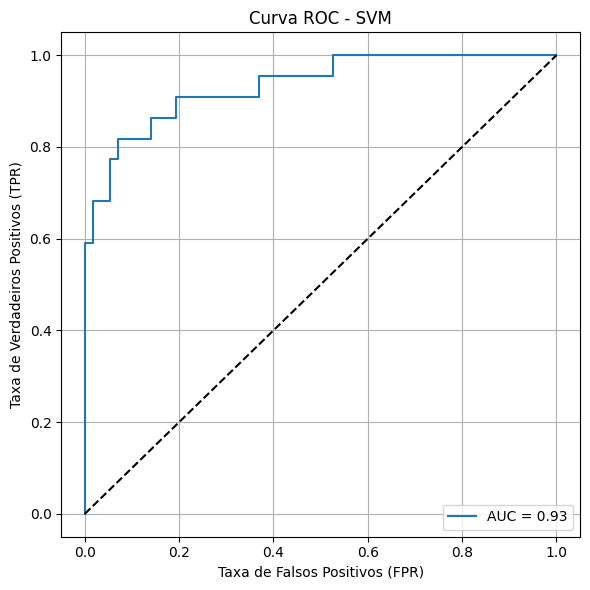

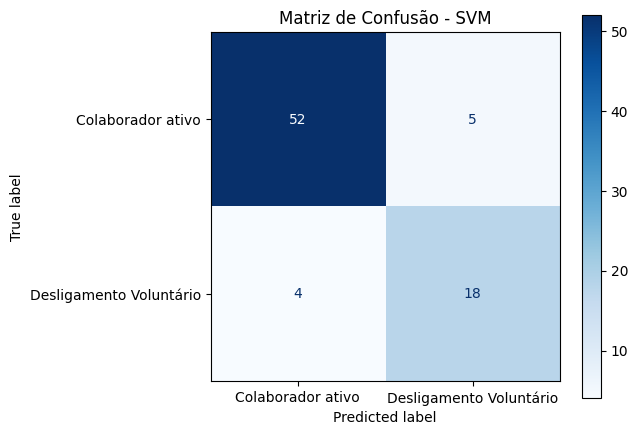


🔍 Treinando e otimizando: KNN
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ Melhor combinação de hiperparâmetros para KNN:
{'classifier__n_neighbors': 3, 'classifier__p': 2, 'classifier__weights': 'distance'}
🎯 Acurácia: 0.77
🎯 F1 Macro: 0.70
📊 Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.82      0.88      0.85        57
         1.0       0.61      0.50      0.55        22

    accuracy                           0.77        79
   macro avg       0.72      0.69      0.70        79
weighted avg       0.76      0.77      0.76        79



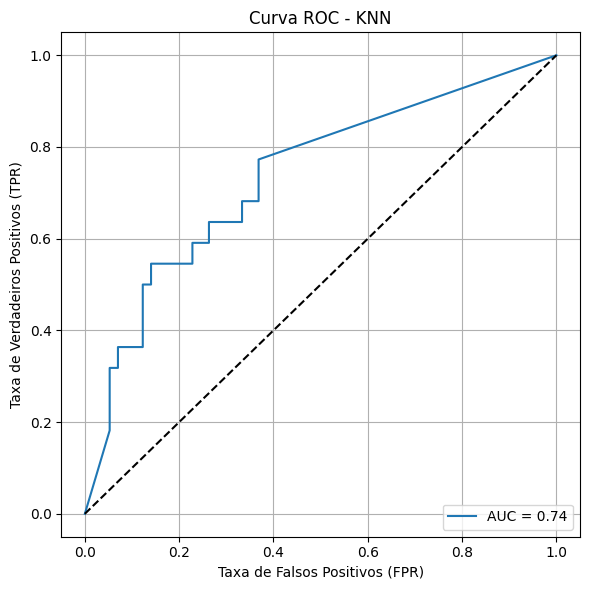

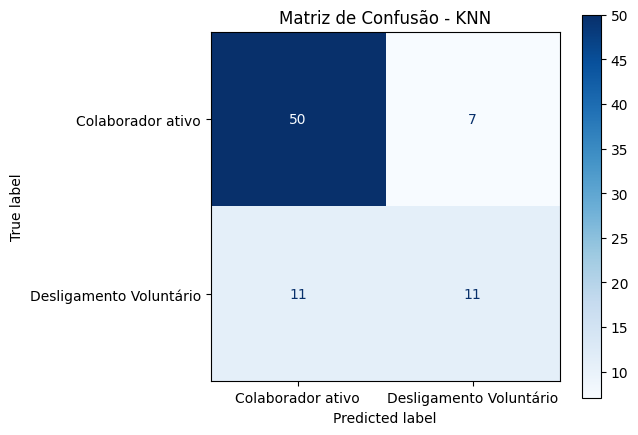


🔍 Treinando e otimizando: GradientBoosting
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Melhor combinação de hiperparâmetros para GradientBoosting:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
🎯 Acurácia: 0.91
🎯 F1 Macro: 0.88
📊 Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        57
         1.0       1.00      0.68      0.81        22

    accuracy                           0.91        79
   macro avg       0.95      0.84      0.88        79
weighted avg       0.92      0.91      0.91        79



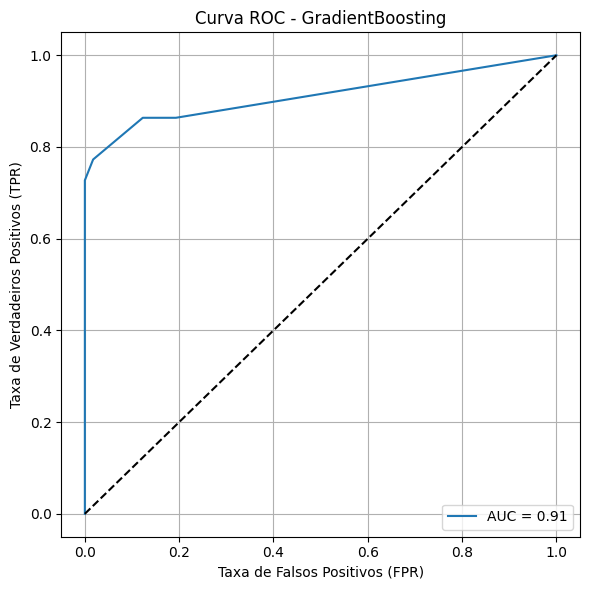

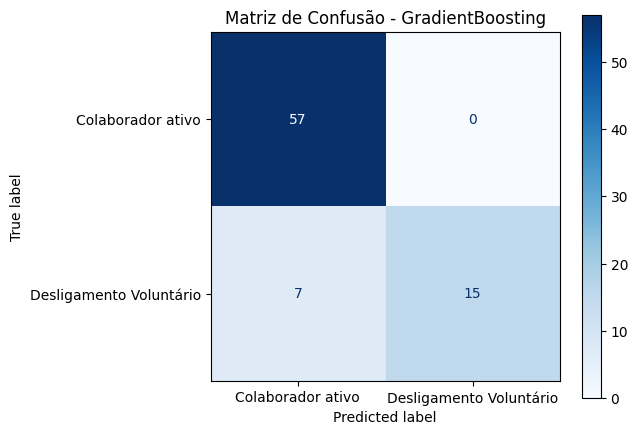


🔍 Treinando e otimizando: XGBoost
Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Melhor combinação de hiperparâmetros para XGBoost:
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
🎯 Acurácia: 0.90
🎯 F1 Macro: 0.86
📊 Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        57
         1.0       1.00      0.64      0.78        22

    accuracy                           0.90        79
   macro avg       0.94      0.82      0.86        79
weighted avg       0.91      0.90      0.89        79



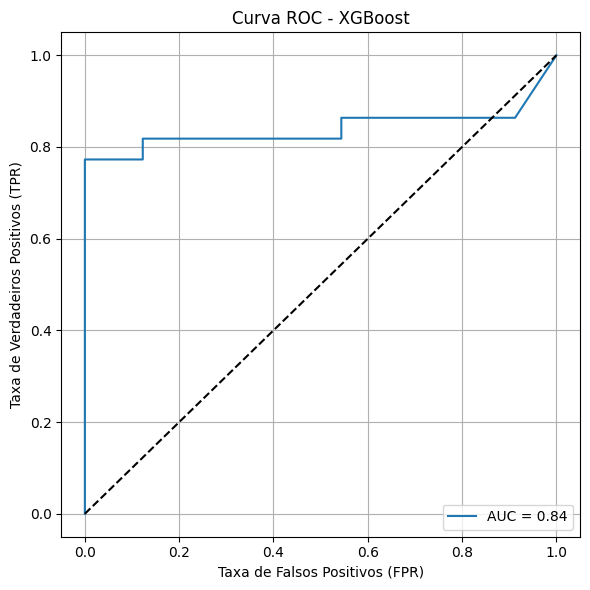

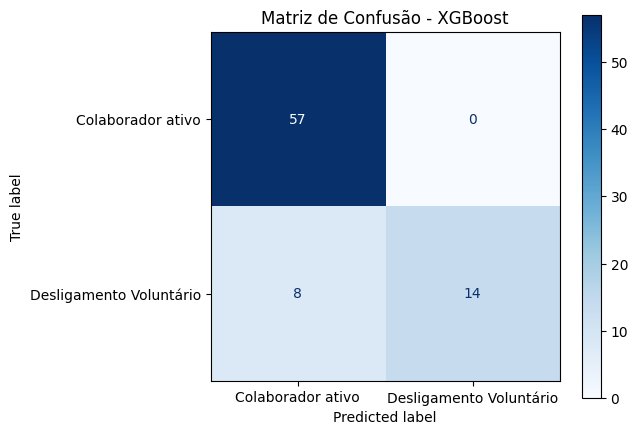

In [46]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
from xgboost import XGBClassifier

import pandas as pd
import numpy as np

# Dividindo os dados
X = df.drop('Y', axis=1)
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Inicializa controle do melhor modelo global
best_overall_model = None
best_overall_score = -1
best_overall_name = ""
best_overall_params = {}
best_overall_y_pred = None

# Validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dicionário de modelos com pipelines e hiperparâmetros
model_params = {
    'RandomForest-withoutImputer': {
        'model': Pipeline([
            ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20],
            'classifier__max_features': [2, 'sqrt', 12], # mtry
            'classifier__max_leaf_nodes': [None],
            'classifier__max_samples': [None],
            'classifier__bootstrap': [True], # replacement
#            'classifier__min_samples_split': [2],
#            'classifier__min_samples_leaf': [1],
            'classifier__criterion': ['gini']
        }
    },
    'RandomForest': {
        'model': Pipeline([
            ('imputer', KNNImputer(n_neighbors=1)),
            ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20],
            'classifier__max_features': [2, 'sqrt', 12], # mtry
            'classifier__max_leaf_nodes': [None],
            'classifier__max_samples': [None],
            'classifier__bootstrap': [True], # replacement
#            'classifier__min_samples_split': [2],
#            'classifier__min_samples_leaf': [1],
            'classifier__criterion': ['gini']
        }
    },
    'LogisticRegression': {
        'model': Pipeline([
            ('imputer', KNNImputer(n_neighbors=1)),
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
        ]),
        'params': {
            'classifier__C': np.logspace(-2, 2, 5),
            'classifier__solver': ['liblinear', 'lbfgs']
        }
    },
    'SVM': {
        'model': Pipeline([
            ('imputer', KNNImputer(n_neighbors=1)),
            ('scaler', StandardScaler()),
            ('classifier', SVC(class_weight='balanced', probability=True))
        ]),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    },
    'KNN': {
        'model': Pipeline([
            ('imputer', KNNImputer(n_neighbors=1)),
            ('scaler', StandardScaler()),
            ('classifier', KNeighborsClassifier())
        ]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7, 9],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__p': [1, 2]
        }
    },
    'GradientBoosting': {
        'model': Pipeline([
            ('imputer', KNNImputer(n_neighbors=1)),
            ('classifier', GradientBoostingClassifier(random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': Pipeline([
            ('imputer', KNNImputer(n_neighbors=1)),
            ('classifier', XGBClassifier(verbosity=0, eval_metric='logloss', class_weight='balanced'))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.8, 1.0]
        }
    }
}

# Loop para otimizar e avaliar
for model_name, mp in model_params.items():
    print(f'\n🔍 Treinando e otimizando: {model_name}')
    
    search = GridSearchCV(
        mp['model'],
        mp['params'],
        #n_iter=10,
        cv=cv_strategy,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1,
        #random_state=42
    )
    
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f'\n✅ Melhor combinação de hiperparâmetros para {model_name}:')
    print(search.best_params_)
    print(f'🎯 Acurácia: {accuracy_score(y_test, y_pred):.2f}')
    print(f'🎯 F1 Macro: {f1_score(y_test, y_pred, average="macro"):.2f}')
    print("📊 Relatório de Classificação:\n", classification_report(y_test, y_pred))

    plot_roc_and_confusion(X_test, y_test, y_pred, model_name, best_model)

    # Verifica se este é o melhor modelo até agora
    if f1 > best_overall_score:
        best_overall_score = f1
        best_overall_model = best_model
        best_overall_name = model_name
        best_overall_params = search.best_params_
        best_overall_y_pred = y_pred

In [47]:
# Imputação dos valores faltantes usando KNN (k=1)
#imputer = KNNImputer(n_neighbors=1)
#X_imputed = imputer.fit_transform(X)

# Treinando o modelo com todos os dados
model = RandomForestClassifier(
    n_estimators = 200,
    max_samples = None,
    max_leaf_nodes = None,
    max_features = 12,
    max_depth = None,
    criterion = 'gini',
    bootstrap = True,
    random_state=42,
    class_weight='balanced'
)
model.fit(X, y)

# Obtendo a importância das features
importances = model.feature_importances_

# Criando um DataFrame para exibir as features e suas importâncias
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Ordenando as features pela importância
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))

                                              Feature  Importance
1                               f_tempo_empresa_meses    0.497593
6                      Nota avaliação desempenho 2023    0.187170
26  Plano Odontológico, PLR, Folga Anual, Reembols...    0.056577
2                         Tempo de experiência (anos)    0.050072
8                              f_Horas_de_treinamento    0.018068
27  Plano Odontológico, PLR, Folga Anual, Reembols...    0.017906
0                             Afastamentos (dias/ano)    0.014277
7                                         f_Faixa_pos    0.013805
37                                                CLT    0.012019
20                           Pós-graduação incompleta    0.011428


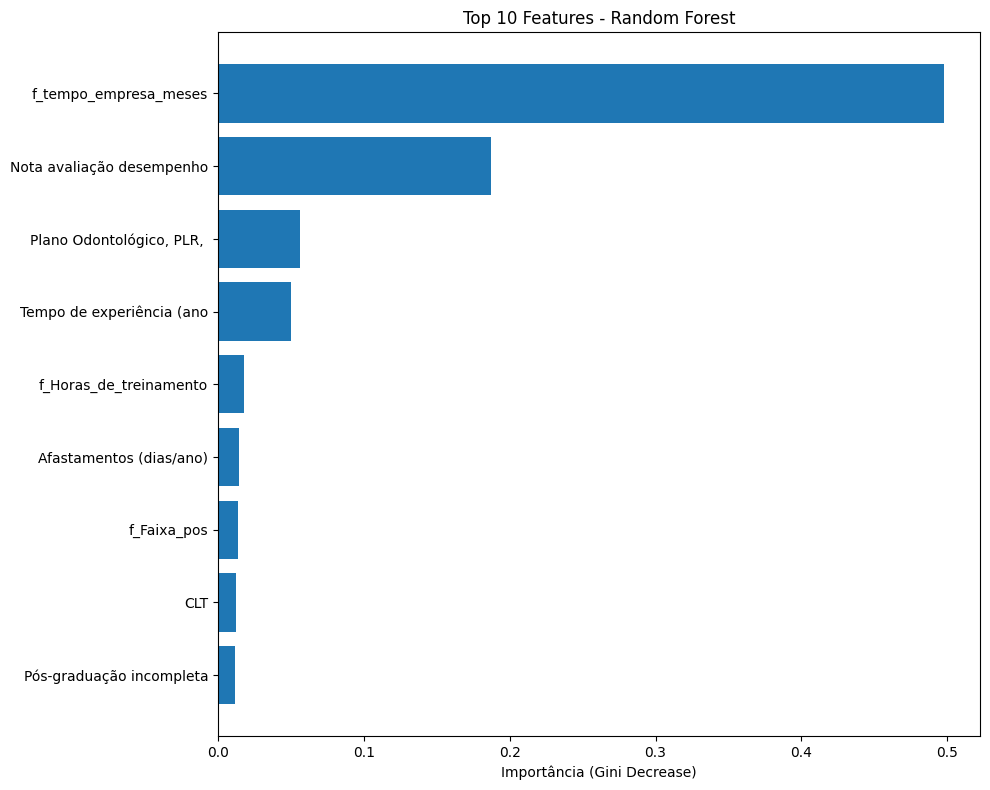

In [48]:
# Seleciona e formata as 10 principais features
top_10_features = feature_importances.head(10).copy()
top_10_features['Feature'] = top_10_features['Feature'].str.slice(0, 25)

plt.figure(figsize=(10, 8))
plt.barh(
    top_10_features['Feature'],
    top_10_features['Importance'],
    align='center'
)
plt.xlabel('Importância (Gini Decrease)')
plt.title('Top 10 Features - Random Forest')
plt.gca().invert_yaxis()  # Inverter para mostrar a mais importante no topo
plt.tight_layout()
plt.show()